In [1]:
import pandas as pd
import pickle
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load the training set
df = pd.read_csv('training_data/utah_training_set.csv').drop(columns=['fid','index','join_key'],errors='ignore')
df = df.dropna(how='any',axis=0)


C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.columns

Index(['timestamp', 'segment_id', 'station_id', 'hour', 'weekday', 'month',
       'pre_dir', 'street_type', 'suf_dir', 'one_way', 'speed_limit',
       'surface_type', 'surface_width', 'aadt', 'sinuosity',
       'euclidean_length', 'segment_length', 'near_major_road',
       'road_orient_approx', 'at_intersection', 'near_billboard',
       'accident_counts', 'target', 'snowing', 'raining', 'foggy', 'icy',
       'hailing', 'thunderstorm', 'wind_speed', 'visibility', 'temperature',
       'precip_depth', 'snow_depth'],
      dtype='object')

In [4]:
#columns=['PREDIR','STREETTYPE','ONEWAY','SURFTYPE','hour','weekday','month']
#ohe_fields=['pre_dir','one_way','surface_type']
ohe_fields=['one_way']
df_ohe = pd.get_dummies(df,columns=ohe_fields)
#df_ohe = df_ohe.dropna(how="any",axis=1)
df_ohe.shape

(4177826, 36)

# Continuous Features
These are currently:
* Severity Density (KDE estimate)
* Speed Limit (if available)
* Sinuosity (Road curavture metric)
* AADT (Annual Average Daily Traffic)
* Precipitation Depth
* Snow Depth
* Temperature
* Visibility
* Wind SPeed

In [5]:
float_feature_names = [
    'accident_counts',
    'speed_limit',
    'aadt',
    'surface_width',
    'sinuosity',
    'euclidean_length',
    'segment_length',
    'road_orient_approx',
    'precip_depth',
    'snow_depth',
    'temperature',
    'visibility',
    'wind_speed'
]
float_features = df_ohe.xs(float_feature_names,axis=1).values

# Not using sklearn's scaler because I have a bunch of missing data and was feeling lazy. :)
mean_float = np.nanmean(float_features,axis=0)
std_float = np.nanstd(float_features,axis=0)

float_scaled = (float_features - mean_float) / std_float

for i,fname in enumerate(float_feature_names):
    df_ohe[fname] = float_scaled[:,i]

with open('scalers.pkl','wb') as fp:
    pickle.dump((float_feature_names,mean_float,std_float),fp)


In [6]:
df.target.describe()

count    4.177826e+06
mean     9.487901e-02
std      2.930478e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: target, dtype: float64

In [7]:
y = df['target'].values
drop_columns = ['index',
                'join_key',
                'segment_id',
                'station_id',
                'timestamp',
                'target',
                'fid',
                'COFIPS',
                'street_type',
                'pre_dir',
                'surface_type',
                'suf_dir']
df_ohe = df_ohe.drop(columns=drop_columns,errors='ignore')

In [8]:
X = df_ohe.values

print (X.shape)


(4177826, 28)


In [9]:
feature_names = df_ohe.columns.tolist()
len(feature_names)

28

In [10]:
print(feature_names)

['hour', 'weekday', 'month', 'speed_limit', 'surface_width', 'aadt', 'sinuosity', 'euclidean_length', 'segment_length', 'near_major_road', 'road_orient_approx', 'at_intersection', 'near_billboard', 'accident_counts', 'snowing', 'raining', 'foggy', 'icy', 'hailing', 'thunderstorm', 'wind_speed', 'visibility', 'temperature', 'precip_depth', 'snow_depth', 'one_way_0', 'one_way_1', 'one_way_2']


In [11]:
wrangler = {
    'float_scaler_mean': mean_float,
    'float_scaler_std': std_float,
    'float_feature_names': float_feature_names,
    'drop_columns': drop_columns,
    'ohe_fields': ohe_fields,
    'feature_names': feature_names
}
with open('wrangler.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

In [12]:

skf = StratifiedShuffleSplit(1)
splits = skf.split(X,y)
help(StratifiedShuffleSplit)

Help on class StratifiedShuffleSplit in module sklearn.model_selection._split:

class StratifiedShuffleSplit(BaseShuffleSplit)
 |  Stratified ShuffleSplit cross-validator
 |  
 |  Provides train/test indices to split data in train/test sets.
 |  
 |  This cross-validation object is a merge of StratifiedKFold and
 |  ShuffleSplit, which returns stratified randomized folds. The folds
 |  are made by preserving the percentage of samples for each class.
 |  
 |  Note: like the ShuffleSplit strategy, stratified random splits
 |  do not guarantee that all folds will be different, although this is
 |  still very likely for sizeable datasets.
 |  
 |  Read more in the :ref:`User Guide <cross_validation>`.
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default 10
 |      Number of re-shuffling & splitting iterations.
 |  
 |  test_size : float, int, None, optional
 |      If float, should be between 0.0 and 1.0 and represent the proportion
 |      of the dataset to include in the test s

In [13]:
(test,train) = list(splits)[0]

In [14]:
X_train = X[train]
y_train = y[train]
X_test = X[test]
y_test = y[test]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)#, random_state=2)

X_train = xgboost.DMatrix(X_train,label=y_train,feature_names=feature_names)
X_test =  xgboost.DMatrix(X_test,label=y_test,feature_names=feature_names)
params = {
    'n_estimators': 200,
    'max_depth':15,
    'min_child_weight': 1.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'objective':'binary:logistic'
}
booster = xgboost.train(params,X_train)

y_pred_test = booster.predict(X_test) > 0.5
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = booster.predict(X_test)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))

y_pred_train = booster.predict(X_train) > 0.5
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = booster.predict(X_train)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))

Test Accuracy: 0.942213964871
Test F1: 0.580273442933
Test Precision: 0.934034074373
Test AP: 0.448072604333
Test Recall: 0.420870784533
Test AUC: 0.892119678118
Train Accuracy: 0.94586993331
Train F1: 0.611231257457
Train Precision: 0.958681607869
Test AP: 0.482393967372
Train Recall: 0.44863473477
Train AUC: 0.916309700328


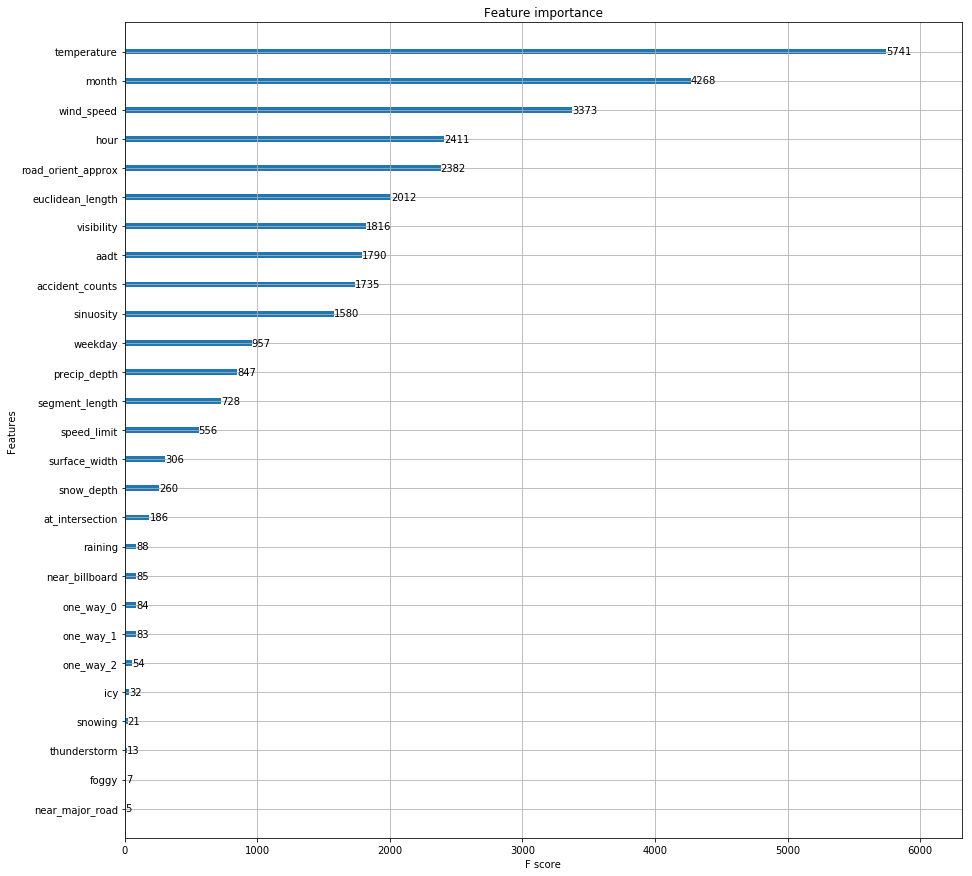

In [15]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='weight')

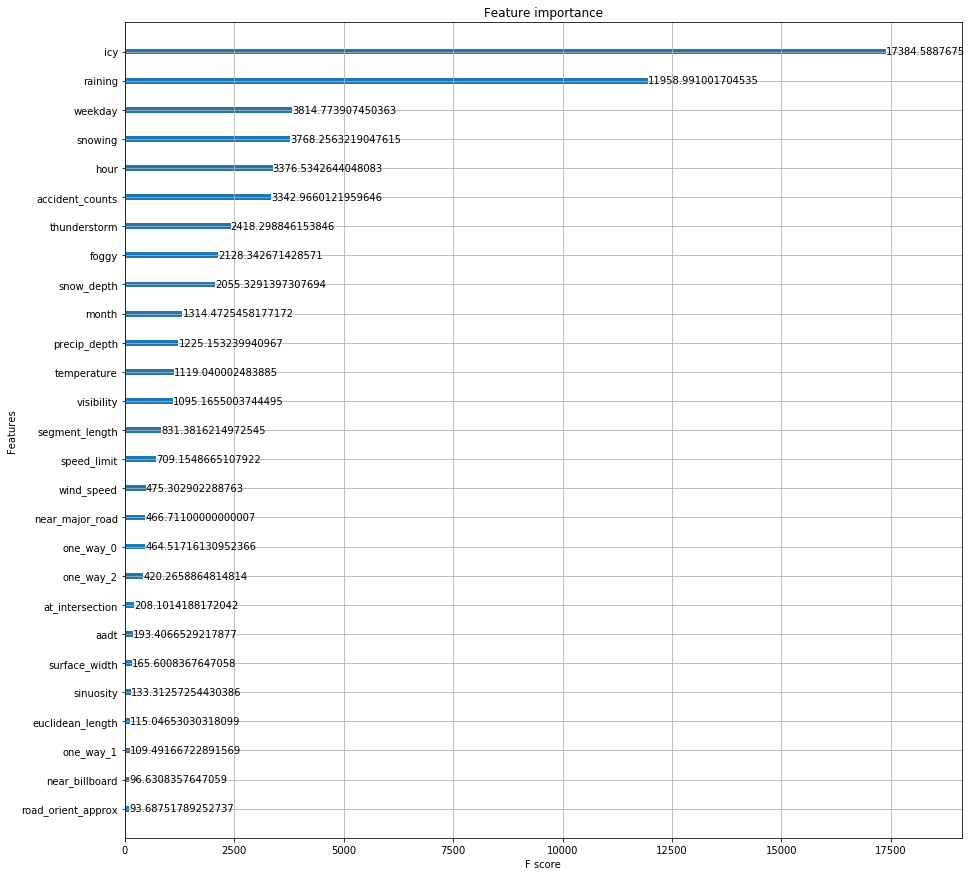

In [16]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='cover')

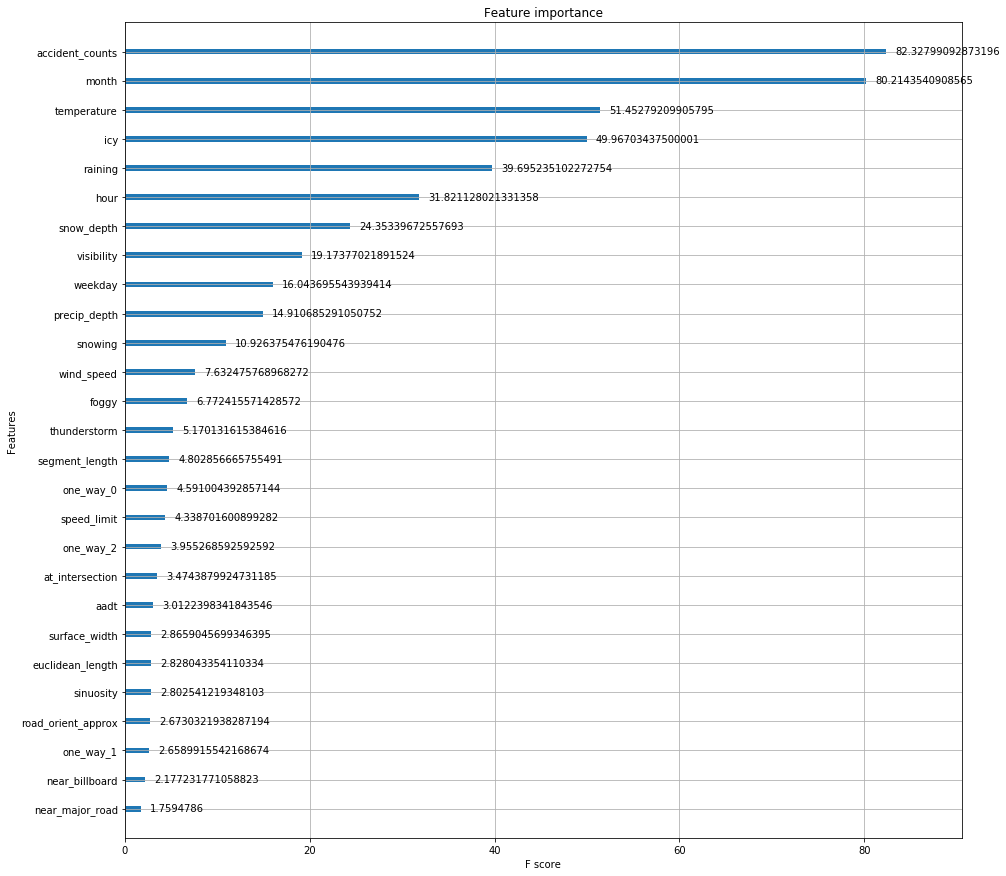

In [17]:
plt.figure(figsize=(15,15))
xgboost.plot_importance(booster,ax=plt.gca(),importance_type='gain')

In [18]:
booster.save_model('0001.model')

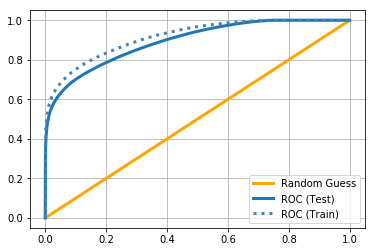

In [19]:
y_pred_test = booster.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)

y_pred_train = booster.predict(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='steelblue',lw=3)
plt.grid()
plt.legend()

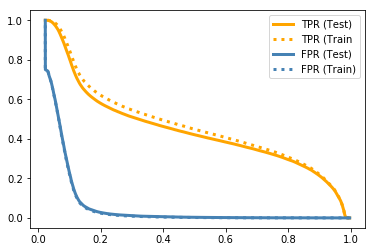

In [20]:

plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='steelblue',lw=3)
plt.legend()

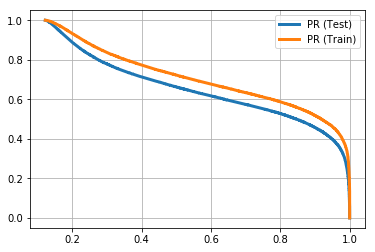

In [21]:
plt.figure(figsize=(15,15))

y_pred_test = booster.predict(X_test)
y_pred_train = booster.predict(X_train)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)

plt.grid()
plt.legend()

In [22]:
len(X_train.feature_names)

28

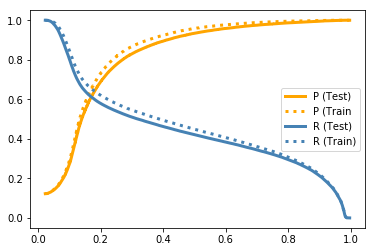

In [23]:
plt.plot(thresholds,precision[:-1],'r-',label='P (Test)',color='orange',lw=3)
plt.plot(thresholds_train,precision_train[:-1],'r:',label='P (Train',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (Test)',color='steelblue',lw=3)
plt.plot(thresholds_train,recall_train[:-1],'r:',label='R (Train)',color='steelblue',lw=3)
plt.legend()